In [1]:
from collections import defaultdict
from itertools import islice, product
import random
import time
from pathlib import Path

import numpy as np
from tqdm.auto import tqdm

import pandas as pd
from sympy import parse_expr, lambdify

import torch
import torch.nn as nn

In [25]:
def parameters(width, depth, dimension):
    """Computes number of parameters in MLP with widths `width`,
    depth `depth`, and input dimension `dimension`. Assumes the neurons
    have biases.
    """
    return (dimension * width + width) + (depth - 2)*(width * width + width) + (width + 1)

def width_given_ddp(depth, dimension, parameters):
    """Given the network depth and input dimension, computes the
    width such that the architecture (with bias) has `parameters` parameters.
    """
    if depth == 2:
        return int((parameters - 1) / (dimension + 2))
    root = (-(dimension + depth) + np.sqrt(np.power(dimension + depth, 2) - 4 * (depth - 2) * (1 - parameters))) / (2 * (depth - 2))
    return int(root)

def create_normalizer(mean, std):
    """Create a function to normalize data of the form (N, d) given the means
    and stds along each of the d columns.

    Args:
        mean: (mean[1], ..., mean[d])
        std: (std[1], ..., std[d])
    """
    assert len(mean) == len(std)
    def normalize(x):
        return torch.stack([(x[:, i] - mean[i]) / std[i] for i in range(len(mean))], dim=1)
    return normalize

def make_mlp(input_dim, depth, width, activation_fn):
    layers = []
    for i in range(depth):
        if i == 0:
            layers.append(nn.Linear(input_dim, width))
            layers.append(activation_fn())
        elif i == depth - 1:
            layers.append(nn.Linear(width, 1))
        else:
            layers.append(nn.Linear(width, width))
            layers.append(activation_fn())
    return nn.Sequential(*layers)

class I_8_14(nn.Module):
    def __init__(self, width, depth, activation_fn, device):
        super().__init__()
        assert depth % 2 == 0, "For this problem, modular architecture has two steps"
        self.device = device
        self.mlpxs = make_mlp(2, depth // 2, width // 2, activation_fn).to(device)
        self.mlpys = make_mlp(2, depth // 2, width // 2, activation_fn).to(device)
        self.mlpaddsqrt = make_mlp(2, depth // 2, width, activation_fn).to(device)
    
    def forward(self, x):
        x = x.to(self.device)
        xs = self.mlpxs(x[:, :2])
        ys = self.mlpys(x[:, 2:])
        return self.mlpaddsqrt(torch.cat([xs, ys], dim=1))


In [26]:
eqn = 'I.8.14'
width = 100
depth = 6
lr = 1e-3
activation = 'ReLU'
N_TEST_POINTS = 30000
TEST_COMPACTIFICATION = 0.8
MAX_TRAIN_ITERS = 25000
MAX_BATCH_SIZE = 30000
spreadsheet = "../equations.csv"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0

In [27]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

equations = pd.read_csv(spreadsheet)
row = equations[equations['Equation'] == eqn].iloc[0]
dimension = int(row['# variables'])
formula = row['Formula']
variables = [row[f'v{i}_name'] for i in range(1, dimension+1)]
ranges = [(row[f'v{i}_low'], row[f'v{i}_high']) for i in range(1, dimension+1)]
target = lambdify(variables, parse_expr(formula))

if activation == 'ReLU':
    activation_fn = nn.ReLU
elif activation == 'Tanh':
    activation_fn = nn.Tanh
elif activation == 'Sigmoid':
    activation_fn = nn.Sigmoid
else:
    assert False, f"Unrecognized activation function identifier: {activation}"

# create model
modular_mlp = I_8_14(width, depth, activation_fn, device)
# _log.debug("Created model.")
# _log.debug(f"Model has {sum(t.numel() for t in modular_mlp.parameters())} parameters")
parameters = sum(t.numel() for t in modular_mlp.parameters())
TRAIN_POINTS = parameters // (dimension + 1)
# ex.info['TRAIN_POINTS'] = TRAIN_POINTS
# _log.debug(f"TRAIN_POINTS: {TRAIN_POINTS}")

# create datasets
ls = np.array([ranges[i][0] for i in range(dimension)])
hs = np.array([ranges[i][1] for i in range(dimension)])
xs_train = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
ys_train = target(*[xs_train[:, i] for i in range(dimension)])

cs = (hs + ls) / 2
ws = (hs - ls) * TEST_COMPACTIFICATION
ls, hs = cs - ws / 2, cs + ws / 2
xs_test = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
ys_test = target(*[xs_test[:, i] for i in range(dimension)])

xs_train = torch.from_numpy(xs_train).to(device)
ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
xs_test = torch.from_numpy(xs_test).to(device)
ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)

normalize = create_normalizer(xs_train.mean(dim=0), xs_train.std(dim=0))
xs_train = normalize(xs_train)
xs_test = normalize(xs_test)

assert xs_train.dtype == dtype
assert ys_train.dtype == dtype
assert xs_test.dtype == dtype
assert ys_test.dtype == dtype


loss_fn = nn.MSELoss()
optim = torch.optim.Adam(modular_mlp.parameters(), lr=lr)

train = list()
test = list()
min_train = float('inf')
min_test = float('inf')
test_at_min_train = float('inf')

k = 0
for step in tqdm(range(MAX_TRAIN_ITERS)):
    optim.zero_grad()
    if TRAIN_POINTS <= MAX_BATCH_SIZE:
        ys_pred = modular_mlp(xs_train)
        l = loss_fn(ys_train, ys_pred)
    else:
        sample_idx = torch.arange(k, k+MAX_BATCH_SIZE, 1) % TRAIN_POINTS
        xs_batch, ys_batch = xs_train[sample_idx], ys_train[sample_idx]
        ys_pred = modular_mlp(xs_batch)
        l = loss_fn(ys_batch, ys_pred)
        k += MAX_BATCH_SIZE
    l.backward()
    optim.step()
    with torch.no_grad():
        train_l = torch.sqrt(l).item()
        test_l = torch.sqrt(torch.mean(torch.pow(modular_mlp(xs_test) - ys_test, 2))).item()
        if train_l < min_train:
            min_train = train_l
            test_at_min_train = test_l
        min_test = test_l if test_l < min_test else min_test
        if step % 100 == 0:
            train.append(train_l)
            test.append(test_l)
    # if step % (MAX_TRAIN_ITERS // 10) == 0:
        # _log.debug("{:.0f}% done with training".format(step / MAX_TRAIN_ITERS * 100))


  0%|          | 0/25000 [00:00<?, ?it/s]

In [28]:
import matplotlib.pyplot as plt

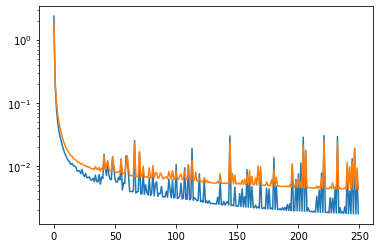

In [29]:
plt.plot(train)
plt.plot(test)
plt.yscale('log')

In [30]:
min(test)

0.004272291154020468

In [31]:
parameters

16003

In [32]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

equations = pd.read_csv(spreadsheet)
row = equations[equations['Equation'] == eqn].iloc[0]
dimension = int(row['# variables'])
formula = row['Formula']
variables = [row[f'v{i}_name'] for i in range(1, dimension+1)]
ranges = [(row[f'v{i}_low'], row[f'v{i}_high']) for i in range(1, dimension+1)]
target = lambdify(variables, parse_expr(formula))

if activation == 'ReLU':
    activation_fn = nn.ReLU
elif activation == 'Tanh':
    activation_fn = nn.Tanh
elif activation == 'Sigmoid':
    activation_fn = nn.Sigmoid
else:
    assert False, f"Unrecognized activation function identifier: {activation}"

# create model
layers = []
for i in range(depth):
    if i == 0:
        layers.append(nn.Linear(dimension, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        layers.append(nn.Linear(width, 1))
    else:
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())
mlp = nn.Sequential(*layers).to(device)

parameters = sum(t.numel() for t in mlp.parameters())
TRAIN_POINTS = parameters // (dimension + 1)
# ex.info['TRAIN_POINTS'] = TRAIN_POINTS
# _log.debug(f"TRAIN_POINTS: {TRAIN_POINTS}")

# create datasets
ls = np.array([ranges[i][0] for i in range(dimension)])
hs = np.array([ranges[i][1] for i in range(dimension)])
xs_train = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
ys_train = target(*[xs_train[:, i] for i in range(dimension)])

cs = (hs + ls) / 2
ws = (hs - ls) * TEST_COMPACTIFICATION
ls, hs = cs - ws / 2, cs + ws / 2
xs_test = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
ys_test = target(*[xs_test[:, i] for i in range(dimension)])

xs_train = torch.from_numpy(xs_train).to(device)
ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
xs_test = torch.from_numpy(xs_test).to(device)
ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)

normalize = create_normalizer(xs_train.mean(dim=0), xs_train.std(dim=0))
xs_train = normalize(xs_train)
xs_test = normalize(xs_test)

assert xs_train.dtype == dtype
assert ys_train.dtype == dtype
assert xs_test.dtype == dtype
assert ys_test.dtype == dtype


loss_fn = nn.MSELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

train = list()
test = list()
min_train = float('inf')
min_test = float('inf')
test_at_min_train = float('inf')

k = 0
for step in tqdm(range(MAX_TRAIN_ITERS)):
    optim.zero_grad()
    if TRAIN_POINTS <= MAX_BATCH_SIZE:
        ys_pred = mlp(xs_train)
        l = loss_fn(ys_train, ys_pred)
    else:
        sample_idx = torch.arange(k, k+MAX_BATCH_SIZE, 1) % TRAIN_POINTS
        xs_batch, ys_batch = xs_train[sample_idx], ys_train[sample_idx]
        ys_pred = mlp(xs_batch)
        l = loss_fn(ys_batch, ys_pred)
        k += MAX_BATCH_SIZE
    l.backward()
    optim.step()
    with torch.no_grad():
        train_l = torch.sqrt(l).item()
        test_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_test) - ys_test, 2))).item()
        if train_l < min_train:
            min_train = train_l
            test_at_min_train = test_l
        min_test = test_l if test_l < min_test else min_test
        if step % 100 == 0:
            train.append(train_l)
            test.append(test_l)
    # if step % (MAX_TRAIN_ITERS // 10) == 0:
        # _log.debug("{:.0f}% done with training".format(step / MAX_TRAIN_ITERS * 100))


  0%|          | 0/25000 [00:00<?, ?it/s]

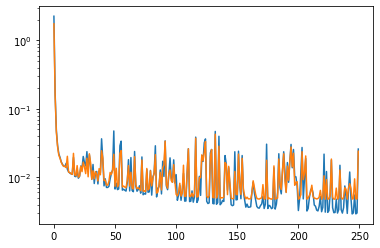

In [22]:
plt.plot(train)
plt.plot(test)
plt.yscale('log')

In [23]:
min(test)

0.004773926341924796

In [24]:
parameters

41001